In [1]:
from cobraInit import cobraInit
from cobraPhaseII import cobraPhaseII

from SACOBRA import getXbest
from SACOBRA import getFbest

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

{'coef': array([ 2.22044605e-15, -2.88657986e-15, -1.44328993e-15, -3.68421053e+00,
        7.63157895e+00,  2.10526316e+00,  2.63157895e-01]), 'xp': array([[1. , 2.5, 3. ],
       [2. , 3.5, 4. ],
       [3. , 4.5, 5. ]]), 'd': 4, 'npts': 3, 'ptail': True, 'squares': False, 'type': 'CUBIC'}
predict  [[2.  3.5 4. ]]
[19.999999999999996]


In [2]:
from lhs import lhs 
from defaultRI import defaultRI
from defaultTR import defaultTR
from transformLHS import transformLHS
from defaultSAC import defaultSAC
from defaultSAC import setOpts

In [3]:
import time
import copy
import warnings
import json

In [4]:
from RbfSurrMixInt import trainCubicRBF
from RbfSurrMixInt import predictRBFinter
from RbfSurrMixInt import interpRBF
from RbfSurrMixInt import distLine

{'coef': array([ 2.22044605e-15, -2.88657986e-15, -1.44328993e-15, -3.68421053e+00,
        7.63157895e+00,  2.10526316e+00,  2.63157895e-01]), 'xp': array([[1. , 2.5, 3. ],
       [2. , 3.5, 4. ],
       [3. , 4.5, 5. ]]), 'd': 4, 'npts': 3, 'ptail': True, 'squares': False, 'type': 'CUBIC', 'integer_indices': [0, 2]}
predict  [[3.  3.5 4. ]]
[27.631578947368357]


In [5]:
from MixIntEs import MixedIntegerOptimizer

In [6]:
from G05 import G05
from G01 import G01
from G02 import G02

In [7]:
DRCL = np.array([0.3,0.05,0.001,0.0005,0.0])
DRCS = np.array([0.001,0.0])

SACOBRA Functions

In [8]:
def verboseprint(verbose, important, message):
    if verbose != 0:
        if verbose==2 or (verbose==1 and important):
            print(message)

In [9]:
def adDRC(maxF, minF):
    FRange = maxF-minF
    if FRange>1e+3:
        print(FRange,'=FR is large, XI is set to short DRC')
        DRC = DRCS
    else:
        DRC = DRCL
        print(FRange,'=FR is not large, XI is set ot Long DRC')
    return DRC

In [10]:
def plog(y, pShift=0.0):
    if y-pShift>=0:
        ret = np.log(1+y-pShift)
    else:
        ret = -np.log(1-(y-pShift))
    return ret

In [11]:
def adFit(cobra,ind):
    maxF = max(cobra['Fres'])
    minF = min(cobra['Fres'])
    FRange = maxF-minF
    
    def transfFunc(x,pShift=0.0):
        y = plog(x, pShift=pShift)
        return(y)    
    #If cobra['online'] PLOG is true then the desciosn to do the plog transfomation or not 
    #is being made in every iteration according to the p-effect otherwise the decision is made once accoridng to the FRange value 
    
    if 'onlinePlog' in cobra['sac'] and cobra['sac']['onlinePlog']:
        pShift = 0
        if cobra['pEffect'] > 1:
            Fres = np.array([transfFunc(fres, pShift) for fres in cobra['Fres'][ind]])
            if 'Plog' in cobra:
                cobra['Plog'].append(True)
            else:
                cobra['Plog'] = [True]
        else:
            Fres = cobra['Fres'][ind]
            pShift = None
            if 'Plog' in cobra:
                cobra['Plog'].append(False)
            else:
                cobra['Plog'] = [False]
    else:
        if FRange > cobra['sac']['TFRange']:
            if cobra['sac']['adaptivePLOG']:
                pShift = np.mean([cobra['fbest'],0])
            else:
                pShift = 0
            Fres = np.array([transfFunc(fres, pShift) for fres in cobra['Fres'][ind]])
            cobra['PLOG'] = [True]
        else:
            Fres = cobra['Fres'][ind]
            pShift = None
            cobra['PLOG'] = [False]
    if 'pShift' in cobra:
        cobra['pShift'].append(pShift)
    else: 
        cobra['pShift'] = [pShift]
    cobra['SurrogateInput'] = Fres
    return(cobra)


In [12]:
def plogReverse(y,pShift=0):
    if y>0:
        ret = np.exp(y)-1+pShift
    else:
        ret = pShift+1-(1/np.exp(y))
    return ret

COBRA initialization

In [13]:
initDesign="LHS"
initDesPoints=None
initDesOptP=None
initBias=0.005
seqOptimizer="COBYLA"
seqFeval=1000
seqTol=1e-6
penaF=[3.0, 1.7, 3e5]
squaresF=True
squaresC=True 
conTol=0.0
constraintHandling="DEFAULT"
sigmaD=[3.0,2.0,100]
repairInfeas=False
ri=defaultRI()
DOSAC=1 
sac=None
epsilonInit=None 
epsilonMax=None 
solu=None
saveIntermediate=False 
saveSurrogates=False
RBFmodel="cubic"
RBFwidth=-1
GaussRule="One"
RBFrho=0.0
skipPhaseI=True
trueFuncForSurrogates=False 
drFactor=1.0
XI=DRCL
rescale=True
newlower=-1
newupper=1  
DEBUG_XI=False 
SKIP_HIGH=False 
DEBUG_RBF=False
TrustRegion=False
TRlist=defaultTR()
verbose=1
verboseIter=1 #10
cobraSeed=1

In [14]:
cobraSeed = 10
fn = G05
fName= 'G05'
lower = np.array([0,0,-0.55,-0.55])
upper = np.array([1200,1200,0.55,0.55])
nConstraints=8
d=4
xStart = lower+np.random.rand(len(upper))*upper
# print("XSTART",xStart)
initDesPoints = 3*d 
feval = 100 #70
seqFeval = 1000
integer_indices = [1]
decimal = 4

In [15]:
# cobraSeed = 10
# np.random.seed(cobraSeed)
# fn = G02
# fName="G02"
# nConstraints = 2
# lower = np.array([-1.5, -0.5])
# upper = np.array([1.5, 2.5])
# d = 2
# xStart = lower+np.random.rand(2)*upper
# initDesPoints = 3*d 
# feval = 100 #70
# seqFeval = 1000
# integer_indices = [1]
# decimal = 4

In [16]:
# cobraSeed =5
# np.random.seed(cobraSeed)

# fn = G01
# fName = 'G01'
# upper = np.array([1,1,1,1,1,1,1,1,1,100,100,100,1])
# lower = np.zeros(len(upper))
# nConstraints = 9
# np.random.seed(1)
# d = 13
# xStart = lower+np.random.rand(len(upper))*upper

# initDesPoints = 3*d 
# cobraSeed = 1
# feval = 100
# seqFeval = 1000
# integer_indices = [1,5,6]

In [17]:
def scaleRescale(xStart, originalL, originalU, newlower, newupper):
    return (newupper-newlower)*((xStart-originalL)/(originalU-originalL))+newlower

def rescaleWrapper(fn,lower,upper,newlower,newupper):
    oldfn = fn
    def newfn(x):
        x = scaleRescale(x,newlower,newupper,lower,upper)
        y = oldfn(x)
        return(y)
    return(newfn)

In [18]:
def RandomStart(cobra):
    seedn = cobra['cobraSeed']+len(cobra['Fres'])
    #print("SEED:",seedn)
    np.random.seed(seedn)
    anewrand = np.random.rand(1)
    
    diff = cobra['sac']['RSmax']-cobra['sac']['RSmin']
    
    if cobra['sac']['RStype']=='SIGMOID':
        tanh = np.tanh(-(len(cobra['A'])-(cobra['initDesPoints']+15)))
        randomnessTemp = (diff/2)*tanh+(diff/2)+cobra['sac']['RSmin']
    elif cobra['sac']['RStype']=='CONSTANT':
        randomnessTemp = diff/2
        
    if anewrand < randomnessTemp or cobra['progressCount'] >= cobra['sac']['Cs']:
        xStart = np.random.uniform(low=cobra['lower'], high = cobra['upper'], size=len(cobra['xbest']))
        cobra['progressCount'] = 0
    else:
        xStart = cobra['xbest']
    
    # xStart[integer_indices] = np.round(xStart[integer_indices])
    cobra['xStart'] = xStart
    return(cobra)
  

In [19]:
def stochasticRounding(x, mu = 0.7):
    np.random.seed(cobraSeed)

    r = np.random.rand()
    if(r < mu):
        x = np.floor(x)
    else:
        x = np.ceil(x)
    return x    

In [20]:
if initDesPoints is None:
        initDesPoints = 2*len(xStart)+1
if sac is None:
        sac = defaultSAC(DOSAC)

In [21]:
epsilonInit = None
epsilonMax = None
initDesOptP = None

In [22]:
originalfn = fn
originalL = lower
originalU = upper
phase = 'init'
dimension = len(xStart)
newlower=-1
newupper=1

In [23]:
lower = np.array([newlower]*dimension)
upper = np.array([newupper]*dimension)
xStart = scaleRescale(xStart, originalL, originalU, newlower, newupper)
fn = rescaleWrapper(fn,originalL,originalU,newlower,newupper)
l = min(upper-lower)

In [24]:
if epsilonInit is None:
    epsilonInit = 0.005*l
if epsilonMax is None:
    epsilonMax = 2*0.005*l
if initDesOptP is None:
    initDesOptP = initDesPoints

In [25]:
def randomResultsFactory(I,fn,nConstraints):
    result = np.empty((nConstraints+1,len(I)))
    for i in range(len(I)):
        result[:,i] = fn(I[i])
    return result

In [26]:
np.random.seed(cobraSeed)
dimension = len(xStart)
iteration = 0

I = np.empty((1,1))
I[:] = np.NaN
Gres = np.empty((1,1))
Gres[:] = np.NaN
Fres = []

In [27]:
if initDesign =='RANDOM':
    np.random.seed(cobraSeed)
    I = np.random.uniform(low=lower,high=upper,size=(initDesPoints-1,dimension))
    I = np.vstack((I,xStart))
    I = np.clip(I,lower,upper)


In [28]:
if initDesign =='LHS':
    np.random.seed(cobraSeed)
    I = lhs(dimension, samples=initDesPoints-1, criterion="center", iterations=5)
    I = transformLHS(I, lower, upper)
    I = np.vstack((I,xStart))
    I = np.clip(I,lower,upper)

In [29]:
#I[integer_indices] = np.round(I[integer_indices])
# I[:,[integer_indices]] = stochasticRounding(I[:,[integer_indices]])
I[:,[integer_indices]] = np.round(I[:,[integer_indices]])

In [30]:
randomResults = randomResultsFactory(I,fn,nConstraints)
Gres = randomResults[1:].T
Fres = randomResults[0]

In [31]:
Tfeas = np.floor(2*np.sqrt(dimension))
Tinfeas = np.floor(2*np.sqrt(dimension))

In [32]:
fe = len(I) #number of function evaluations
fbest = []
xbest = []
fbestArray = []
xbestArray = np.empty((1,1))
xbestArray[:] = np.NaN

In [33]:
numViol = np.sum(Gres>0,axis=1)
    
maxViol = np.max([np.zeros(len(Gres)),np.max(Gres, axis=1)],axis=0)

A = I #contains all evaluated points
n = len(A)

In [34]:
if 0 in numViol:
    fbestI = np.argmin(Fres[numViol==0])
    fbest = Fres[fbestI]
    xbest = I[fbestI]
    ibest = fbestI
else:
    minNumIndex = np.where(numViol==min(numViol))[0]
    FresMin = Fres[minNumIndex]
    ind = np.argmin(FresMin)
    index = minNumIndex[ind]
    
    fbest = Fres[index]
    xbest = A[index]
    ibest = index

In [35]:
fbestArray = np.array([fbest]*initDesPoints)
xbestArray = np.tile(xbest,(n,1))

In [36]:
cobra = dict()
cobra['CONSTRAINED'] = True
cobra['fn'] = fn
cobra['xStart'] = xbest
cobra['fName'] = fName
cobra['dimension'] = dimension
cobra['nConstraints'] = nConstraints
cobra['lower'] = lower
cobra['upper'] = upper
cobra['newlower'] = newlower
cobra['newupper'] = newupper
cobra['originalL'] = originalL
cobra['originalU'] = originalU
cobra['originalfn'] = originalfn
cobra['rescale'] = rescale
cobra['feval'] = feval
cobra['A'] = A
cobra['fbestArray'] = fbestArray
cobra['xbestArray'] = xbestArray
cobra['xbest'] = xbest
cobra['fbest'] = fbest
cobra['ibest'] = ibest
cobra['Fres'] = Fres
cobra['Gres'] = Gres
cobra['numViol'] = numViol
cobra['maxViol'] = maxViol
cobra['epsilonInit'] = epsilonInit
cobra['epsilonMax'] = epsilonMax
cobra['XI'] = XI
cobra['drFactor'] = drFactor
cobra['Tinfeas'] = Tinfeas
cobra['Tfeas'] = Tfeas
cobra['iteration'] = iteration
cobra['initDesPoints'] = initDesPoints
cobra['seqOptimizer'] = seqOptimizer
cobra['ptail'] = True
cobra['seqFeval'] = seqFeval
cobra['seqTol'] = seqTol
cobra['penaF'] = penaF
cobra['sigmaD'] = sigmaD
cobra['squaresF'] = squaresF
cobra['squaresC'] = squaresC
cobra['cobraSeed'] = cobraSeed
cobra['conTol'] = conTol
cobra['constraintHandling'] = constraintHandling
cobra['l'] = l
cobra['repairInfeas'] = repairInfeas
cobra['ri'] = ri
cobra['fe'] = fe
cobra['saveIntermediate'] = saveIntermediate
cobra['saveSurrogates'] = saveSurrogates
cobra['RBFmodel'] = RBFmodel
cobra['RBFwidth'] = RBFwidth
cobra['RBFrho'] = RBFrho
cobra['RULE'] = GaussRule
cobra['widthFactor'] = 1.0
cobra['skipPhaseI'] = skipPhaseI
cobra['trueFuncForSurrogates'] = trueFuncForSurrogates
cobra['solu'] = solu
cobra['TrustRegion'] = TrustRegion
cobra['TRlist'] = TRlist
cobra['radi'] = np.array([TRlist['radiInit']]*initDesPoints)
cobra['sac'] = sac
cobra['TRDONE'] = [False]*initDesPoints
cobra['TRind'] = []
cobra['refinedX'] = []
cobra['fCount'] = 0
cobra['sCount'] = 0
cobra['DOSAC'] = DOSAC
cobra['PLOG'] = False
cobra['pShift'] = [0]
cobra['pEffect'] = None
cobra['progressCount'] = 0
cobra['DEBUG_XI'] = DEBUG_XI
cobra['DEBUG_RBF'] = DEBUG_RBF
cobra['SKIP_HIGH'] = SKIP_HIGH
cobra['verbose'] = verbose
cobra['verboseIter'] = verboseIter
cobra['phase'] = [phase]*initDesPoints
    
cobra['ri'] = setOpts(cobra['ri'],defaultRI())

In [37]:
if DOSAC>0:
    verboseprint(cobra['verbose'], False, 'Parameter and function adjustment phase')
    cobra['sac'] = setOpts(cobra['sac'], defaultSAC(DOSAC))
    if 'sac' in cobra:
        cobra['pEffect'] = cobra['sac']['pEffectInit']
    else:
        cobra['pEffect'] = 0
    cobra['TRlist'] = setOpts(cobra['TRlist'], defaultTR())
    
    if 'sac' in cobra:
        if 'aDRC' in cobra['sac']:
            if len(XI)!=len(DRCL):
                warnings.warn('Xi is differnt from default DRCL but sac[aDRC] is true, so XI will be set by automatic DRC adjustment' ,DeprecationWarning)
            elif np.any(XI!=DRCL):
                warnings.warn('Xi is differnt from default DRCL but sac[aDRC] is true, so XI will be set by automatic DRC adjustment' ,DeprecationWarning)
        verboseprint(cobra['verbose'], False, "adjusting DRC")
        DRC = adDRC(np.max(cobra['Fres']),np.min(cobra['Fres']))
        cobra['XI'] = DRC

6967.320811419985 =FR is large, XI is set to short DRC


COBRA Phase II

In [38]:
constraintSurrogates = None
fitnessSurrogate = None
fitnessSurrogate1 = None
fitnessSurrogate2 = None

constraintPrediction = None
penaF = cobra['penaF']
sigmaD = cobra['sigmaD']
cobra['important'] = False

In [39]:
newErr1 = 0
newErr2 = 0
err1 = np.array([])
err2 = np.array([])
fn = cobra['fn']
CHECKDIST = True
Tfeas = cobra['Tfeas']
Tinfeas = cobra['Tinfeas']
Cfeas = 0 # Starting Counters
Cinfeas = 0
EPS = np.array([cobra['epsilonInit']]*cobra['nConstraints']) # Initializing margin for all constraints
n = len(cobra['A'])
nRepair = 0

In [40]:
if n==cobra['initDesPoints']:
    predY = np.empty(cobra['initDesPoints'])
    predY[:] = np.nan # structure to store surrogate optimization results
    predVal = np.empty(cobra['initDesPoints'])
    predVal[:] = np.nan
    if cobra['nConstraints']!=0:
        cobra['predC'] = np.empty((cobra['initDesPoints'], cobra['nConstraints'])) # matrix to store predicted constraint values
        cobra['predC'][:] = np.nan
        feas = np.array([not any(cobra['Gres'][i]>0) for i in range(len(cobra['Gres']))])# feasibility of initial design
    feasPred = np.empty(cobra['initDesPoints'])
    feasPred[:] = np.nan
    optimizerConvergence = np.ones(cobra['initDesPoints']) # vector to store optimizer convergence
    cobra['optimizationTime'] = np.zeros(cobra['initDesPoints'])
    feval = np.empty(cobra['initDesPoints'])
    feval[:] = np.nan
    fbestArray = np.empty(cobra['initDesPoints'])
    fbestArray[:] = cobra['fbest']

In [41]:
def trainSurrogates(cobra):
    if cobra['SKIP_HIGH']:
        quFres = np.percentile(cobra['Fres'], 90)
        ind = np.where(cobra['Fres']<=quFres)[0]
    else:
        ind = np.arange(0,len(cobra['Fres']))
    
    A = cobra['A'][ind]
    
    if cobra['sac']['aFF']:
        cobra = adFit(cobra,ind)
        Fres = cobra['SurrogateInput']
    else:
        Fres = cobra['Fres'][ind]

    
    Gres = cobra['Gres'][ind]
    
    if cobra['RBFmodel'] == 'cubic':
        global constraintSurrogates
        constraintSurrogates = []
        for g in Gres.T:
            gresi = np.array(g)
            constraintSurrogates.append(trainCubicRBF(A,gresi,integer_indices=integer_indices,ptail=cobra['ptail'],squares=cobra['squaresC'],rho=cobra['RBFrho']))
            
        global fitnessSurrogate
        fitnessSurrogate = trainCubicRBF(A,Fres,integer_indices=integer_indices,ptail=cobra['ptail'],squares=cobra['squaresF'],rho=cobra['RBFrho'])
    else:
        raise ValueError('To be implemented or invalid RBFmodel')
    
    if cobra['DEBUG_RBF']:
        raise ValueError('To be implemented')
        
    #possibilty to measure p-effect after every 10 iterations
    if (cobra['sac']['onlinePLOG'] and len(cobra['A'])%cobra['sac']['onlineFreqPLOG']==0) or len(cobra['A'])==cobra['initDesPoints']:
        Fres1 = cobra['Fres']
        Fres2 = np.array([plog(fre) for fre in cobra['Fres']])
        
        if cobra['RBFmodel']=='cubic':
            global fitnessSurrogate1
            fitnessSurrogate1 = trainCubicRBF(A,Fres1,integer_indices=integer_indices,ptail=cobra['ptail'],squares=cobra['squaresF'],rho=cobra['RBFrho'])
            global fitnessSurrogate2
            fitnessSurrogate2 = trainCubicRBF(A,Fres2,integer_indices=integer_indices,ptail=cobra['ptail'],squares=cobra['squaresF'],rho=cobra['RBFrho'])
        else:
            raise ValueError('To be implemented or invalid RBFmodel')
    
    return(cobra)

In [42]:
def subProb2(x):
    global cobra
    global fitnessSurrogate
    if np.any(np.isnan(x)):
        return np.inf
    if cobra['trueFuncForSurrogates']:
        y = cobra['fn'](x)[0]
    else:
        # print("sub prob")
        y = predictRBFinter(fitnessSurrogate,np.asmatrix(x))
    # print("y" , y)
    return(y[0])

In [43]:
def getConstraintPrediction(x, constraintSurrogates, EPS=None):        
        constraintPrediction = []
        consi = 0
        for constraintSurrogate in constraintSurrogates:
            if EPS is None:
                constraintPrediction.append(interpRBF(np.asmatrix(x),constraintSurrogate))
            else:
                constraintPrediction.append(interpRBF(np.asmatrix(x),constraintSurrogate)+EPS[consi]**2)
            consi += 1
        constraintPrediction = np.array(constraintPrediction)
        return constraintPrediction

In [44]:
def gCOBRA(x):
    global cobra
    global ro
    global constraintPrediction
    global EPS
    global constraintSurrogates
    x = np.matrix(x)
    distance = distLine(x, cobra['A'])
    subC = np.maximum(ro-distance,np.zeros(len(distance)))
    h = np.sum(subC)*cobra['drFactor']

    constraintPrediction = getConstraintPrediction(x, constraintSurrogates, EPS)
    
    if np.any(np.isnan(x)):
        warnings.warn('gCOBRA: x value is NaN, returning Inf',DeprecationWarning)
        return(np.full(x.shape, np.inf))
    
    h = np.append(np.array([-1*h]), -1*constraintPrediction)   
    return(h) 

In [45]:
def checkDistanceReq(subMin, constraintSurrogates, sigmaD, CHECKDIST):
        if CHECKDIST:
            global ro
            ed = ro-distLine(subMin['x'], constraintSurrogates['xp'])
            violatedDist = np.where(ed>0)[0]
            if len(violatedDist)>0:
                if sigmaD[0]*sigmaD[1]<sigmaD[2]:
                    sigmaD[0] = sigmaD[0]*sigmaD[1]
                    verboseprint(cobra['verbose'], False, "increasing sigmaD to: "+str(sigmaD[0])+" at iteration "+str(n))
        return(sigmaD)

In [46]:
def getPredY(xNew, fitnessSurrogate, cobra):
        predy = interpRBF(np.asmatrix(xNew), fitnessSurrogate)
        if cobra['PLOG'][len(cobra['PLOG'])-1]:
            predy = plogReverse(predy,cobra['pShift'][len(cobra['pShift'])-1])
        return(predy)

In [47]:
def getPredY1(xNew, fitnessSurrogate, cobra):
        predy = interpRBF(np.asmatrix(xNew), fitnessSurrogate)
        return(predy)

In [48]:
def updateInfoAndCounters(cobra, xNew, xNewEval, newNumViol, newMaxViol, phase):
        cobra['A'] = np.vstack((cobra['A'], xNew))
        cobra['Fres'] = np.append(cobra['Fres'], xNewEval[0])
        cobra['Gres'] = np.vstack((cobra['Gres'], xNewEval[1:]))
        cobra['numViol'] = np.append(cobra['numViol'], newNumViol)
        cobra['maxViol'] = np.append(cobra['maxViol'], newMaxViol)
        cobra['phase'] = np.append(cobra['phase'], phase)
        if len(cobra['A'])%cobra['verboseIter']==0:
            cobra['important']=True
        else:
            cobra['important']=False   
        cobra['important']=True         
        xNewIndex = len(cobra['numViol'])-1

        realXbest = getXbest(cobra)
        verboseprint(cobra['verbose'], cobra['important'], 'Best Result '+phase+' '+str(len(cobra['A']))+': objValue = '+str(cobra['fbest'])+', x='+str(realXbest)+', viol='+str(cobra['maxViol'][cobra['ibest']]))
        
        global Cfeas
        global Cinfeas
        if cobra['numViol'][xNewIndex]==0:
            Cfeas += 1
            Cinfeas = 0
        else:
            Cinfeas += 1
            Cfeas = 0
        return(cobra)

In [49]:
def adjustMargins(Cfeas,Tfeas,Cinfeas,Tinfeas,EPS,epsMax):
        if Cfeas>=Tfeas:
            EPS = EPS/2
            
            verboseprint(cobra['verbose'], False, 'reducing epsilon to: '+str(EPS[0]))
            Cfeas = 0
        
        if Cinfeas >= Tinfeas:
            EPS = np.minimum(2*EPS,epsMax)
            verboseprint(cobra['verbose'], False, 'increasing epsilon to: '+str(EPS[0]))
            Cfeas = 0
        return(Cfeas, EPS)

In [50]:
def updateSaveCobra(cobra, xNew, feas, feasPred, feval, optimizerConvergence,
                        predY, predVal, subMin, sigmaD, penaF, gama, EPS):
        xNewIndex = len(cobra['numViol'])-1
        
        if cobra['numViol'][cobra['ibest']]==0:
            if cobra['numViol'][xNewIndex]==0 and cobra['Fres'][xNewIndex]<cobra['fbest']:
                cobra['xbest'] = xNew
                cobra['fbest'] = cobra['Fres'][xNewIndex]
                cobra['ibest'] = xNewIndex
                cobra['progressCount'] = 0
        else:
            if cobra['numViol'][xNewIndex]==0:
                cobra['xbest'] = xNew
                cobra['fbest'] = cobra['Fres'][xNewIndex]
                cobra['ibest'] = xNewIndex
                cobra['progressCount'] = 0
                
        cobra['fbestArray'] = np.append(cobra['fbestArray'],cobra['fbest'])
        cobra['xbestArray'] = np.vstack((cobra['xbestArray'],cobra['xbest']))
        
        solu = cobra['solu']
        if solu is None:
            solu=subMin['x']
        else:
            raise ValueError('to be implemented')

        if cobra['saveSurrogates']:
            cobra['constraintSurrogates'] = constraintSurrogates
            cobra['fitnessSurrogate'] = fitnessSurrogate
        
        if cobra['saveIntermediate']:
            cobraResult = copy.deepcopy(cobra)
            for d in cobraResult:
                d['corr'] = 'corr'
                d['regr'] = 'regr'
                for key in d:
                    if type(d[key]) is np.ndarray:
                        d[key] = d[key].tolist()
            
            with open('gauss_model.json', 'w') as fOut:
                json.dump(cobraResult, fOut)
        
        return(cobra)

In [51]:
optimizer = MixedIntegerOptimizer(subProb2,lower=lower, upper=upper, max_eval=1000, minimize=True, integer_indices=integer_indices)

In [52]:
results_arr = []

In [53]:
while n < cobra['feval']:
        ##########################################################
        # STEP6.1: UPDATE RBF MODEL for fitness and constratnit  #
        ##########################################################

        #checken of dit goed is!!!!!
        cobra = trainSurrogates(cobra)  # side effect: constraintSurrogates, fitnessSurrogate
        
        ##########################################################
        # STEP6.2: Determine Distance requirement                #
        ##########################################################
        
        gama = cobra['XI'][((len(cobra['A'])-nRepair) % len(cobra['XI']))]
        
        ro = gama*cobra['l']
        
        ##########################################################
        # STEP6.3: Select Iterate                                #
        ##########################################################
        
        ptm = time.time()
        
        subMin = []
        
        
        if cobra['sac']['RS']:
            cobra = RandomStart(cobra)
            xStart = cobra['xStart']
        else:
            xStart = cobra['xStart']

        # pred = subProb2(xStart, integer_indices = integer_indices)   
        # print("pred ",pred)
            
        if cobra['seqOptimizer']=='COBYLA':            
            cons = []
            cons.append({'type':'ineq','fun':gCOBRA})
            
            for factor in range(len(cobra['lower'])):
                lower = cobra['lower'][factor]
                l = {'type':'ineq','fun': lambda x, lb=lower, i=factor: x[i]-lb}
                cons.append(l)
            for factor in range(len(cobra['upper'])):
                upper = cobra['upper'][factor]
                u = {'type':'ineq','fun': lambda x, ub=upper, i=factor: ub-x[i]}
                cons.append(u)
            
            opts = {'maxiter':cobra['seqFeval'], 'tol':cobra['seqTol']}
            subMin = optimize.minimize(subProb2, xStart, constraints=cons, options=opts, method='COBYLA')
            subMin['feval'] = subMin['nfev']
        else:
            raise ValueError("To Be implemented")
        
        cobra['optimizationTime'] = np.append(cobra['optimizationTime'], time.time()-ptm)
        verboseprint(cobra['verbose'], False, "finished "+str(subMin['feval'])+" iterations, "+str(cobra['optimizationTime'][len(cobra['optimizationTime'])-1])+" sec.")
        
        if penaF[0]*penaF[1] < penaF[2]:
            penaF[0] = penaF[0]*penaF[1]
            
        sigmaD = checkDistanceReq(subMin, fitnessSurrogate, sigmaD, CHECKDIST)
        cobra['progressCount'] = cobra['progressCount']+1
        cobra['fe'] = cobra['fe']+1
        
        xNew = subMin['x']
        xNew = np.maximum(xNew, cobra['lower'])
        xNew = np.minimum(xNew, cobra['upper'])
        newPredY = getPredY(xNew, fitnessSurrogate, cobra)
        if cobra['trueFuncForSurrogates']:
            newPredY = fn(xNew)[0]
        
        predY = np.append(predY, newPredY)
        predVal = np.append(predVal, subMin['fun'])
        feval = np.append(feval, subMin['feval'])
        optimizerConvergence = np.append(optimizerConvergence, subMin['status'])
        
        cobra['predC'] = np.vstack((cobra['predC'], getConstraintPrediction(xNew,constraintSurrogates)))
        
        xNew[integer_indices] = np.round(xNew[integer_indices])
        xNewTemp = xNew
        xNewEval = fn(xNewTemp)

        if (((len(cobra['A'])%cobra['sac']['onlineFreqPLOG'])==0 and cobra['sac']['onlinePLOG']) 
            or (len(cobra['A'])==cobra['initDesPoints'])):
            
            newPredY1 = getPredY1(xNew, fitnessSurrogate1, cobra)
            newPredY2 = getPredY1(xNew, fitnessSurrogate2, cobra)
            newErr1 = np.abs(newPredY1-xNewEval[0])
            newErr2 = np.abs(plogReverse(newPredY2)-xNewEval[0])
            
            err1 = np.append(err1, newErr1)
            err2 = np.append(err2, newErr2)
            errRatio = err1/err2
            
            if np.isinf(newErr2):
                errRatio[len(errRatio)-1] = 0
            elif np.isinf(newErr1):
                errRatio[len(errRatio)-1] = np.inf
            
            cobra['pEffect'] = np.log10(np.nanpercentile(errRatio,75))
        
        newNumViol = np.sum(xNewEval[1:] > cobra['conTol'])
        feas = np.append(feas, newNumViol<1)
        newNumPred = np.sum(cobra['predC'][len(cobra['predC'])-1] > cobra['conTol'])
        feasPred = np.append(feasPred, newNumPred<1)
        
        if max(0,max(xNewEval[1:]))>cobra['conTol']:
            newMaxViol = max(0, max(xNewEval[1:]))
        else:
            newMaxViol = 0

        cobra = updateInfoAndCounters(cobra, xNew, xNewEval, newNumViol, newMaxViol, phase)
        
        Cfeas, EPS = adjustMargins(Cfeas, Tfeas, Cinfeas, Tinfeas, EPS, cobra['epsilonMax'])
        
        n = len(cobra['A'])

        results_arr.append(cobra["fbest"])

        
        cobra = updateSaveCobra(cobra, xNew, feas, feasPred, feval, optimizerConvergence, 
                                predY, predVal, subMin, sigmaD, penaF, gama, EPS)

predict  [[-0.03663788 -0.15892393  0.718364   -0.65767689]]
predict  [[ 0.96336212 -0.15892393  0.718364   -0.65767689]]
predict  [[-0.03663788  0.84107607  0.718364   -0.65767689]]
predict  [[-0.03663788 -0.15892393  1.718364   -0.65767689]]
predict  [[-0.03663788 -0.15892393  1.718364    0.34232311]]
predict  [[-0.09890505  0.83317284  0.36800783 -0.63181035]]
predict  [[-0.09890505  0.83317284  0.34960061 -0.88113178]]
predict  [[-0.34506833  0.83317284  0.41152011 -0.63502283]]
predict  [[ 0.24126606  0.57574069  0.14087329 -0.7599595 ]]
predict  [[ 3.04031247e-04  8.27232473e-01  3.33967285e-01 -6.65850897e-01]]
predict  [[-3.85092230e-04  7.64787740e-01  3.36176408e-01 -6.67095974e-01]]
predict  [[-0.01325964  0.82519064  0.27301664 -0.66408275]]
predict  [[-0.05484067  0.82777575  0.34698579 -0.63947789]]
predict  [[-0.01274266  0.82801367  0.33602318 -0.69416184]]
predict  [[-0.00658906  0.82730038  0.3355946  -0.66255427]]
predict  [[ 0.00947855  0.81831213  0.32600588 -0.669

In [54]:
G05([ 6.79983641e+02 , 1.20000000e+03 , 1.18848921e-01, -3.96246514e-01])

array([ 5.90636023e+03, -3.49045650e-02, -1.06509543e+00, -1.98893712e-04,
       -1.10628835e-06,  1.73973952e+02, -1.73974152e+02, -1.99232351e-04,
       -7.67649478e-07])

In [55]:
print(getXbest(cobra))
print(getFbest(cobra))

[54.54545455  0.         -0.3        -0.5       ]
163.79864763335843


In [56]:
data1 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g01 1")
data2 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g01 5")
data3 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g01 10")

In [57]:
np.mean(np.vstack((data1, data2, data3)), axis = 0)[:80].shape

(80,)

In [58]:
data_g1 = np.vstack((data1, data2, data3))
data_g1 = np.mean(data_g1, axis=0)
data_g1 = data_g1[:80]

In [59]:
data_g1

array([-83.76229224, -13.7497    , -13.7497    , -14.9997    ,
       -14.9997    , -14.9997    , -14.9997    , -14.9997    ,
       -14.9997    , -14.9997    , -14.9997    , -14.999925  ,
       -14.999925  , -14.999925  , -14.999925  , -14.999925  ,
       -14.999925  , -14.999925  , -14.999925  , -14.999925  ,
       -14.999925  , -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99998125,
       -14.99998125, -14.99998125, -14.99998125, -14.99

In [60]:
data1 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g02 1")
data2 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g02 5")
data3 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g02 10")

In [61]:
data_g2 = np.vstack((data1, data2, data3))
data_g2 = np.mean(data_g2, axis=0)
data_g2 = data_g2[:80]

In [62]:
data1 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g05 1")
data2 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g05 5")
data3 = np.loadtxt("D:/thesis/mix-int-sacobra/python/SACOBRA/results/rbf-cobyla  g05 10")

In [63]:
data_g3 = np.vstack((data1, data2, data3))
data_g3 = np.mean(data_g3, axis=0)
data_g3 = data_g3[:80]

In [64]:
import matplotlib.pyplot as plt

In [65]:
data_g3

array([499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18557476,
       499.18557476, 499.18557476, 499.18557476, 499.18

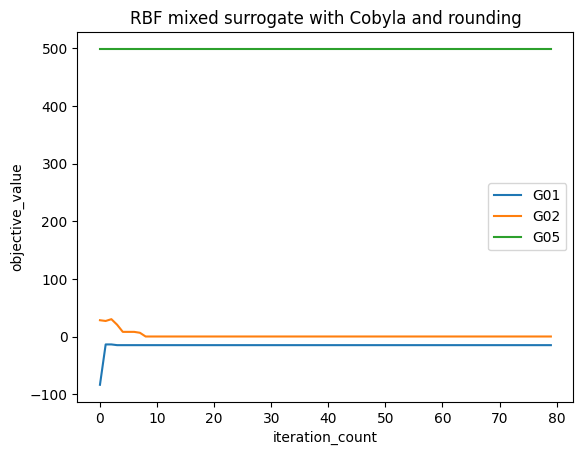

In [66]:
x = np.arange(0, len(data_g1))
y1 = data_g1
y2 = data_g2
y3 = data_g3
# Create the plot
plt.plot(x, y1, label='G01')
plt.plot(x, y2, label='G02')
plt.plot(x, y3, label='G05')

# Add titles and labels
plt.title("RBF mixed surrogate with Cobyla and rounding")
plt.xlabel("iteration_count")
plt.ylabel("objective_value")

plt.legend()

# Show the plot
plt.show()